House Price Predictions - Regresion

Modules

In [ ]:
# Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm
from xgboost import XGBRegressor

# Configuration
import warnings
warnings.filterwarnings("ignore")

#Seed
import random
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

#### Data Manipulation & Feature Engineering

In [253]:
data = pd.read_csv('../Data/train.csv', sep = ';')
data.drop(columns='Id', inplace=True)
data.shape

(1460, 80)

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

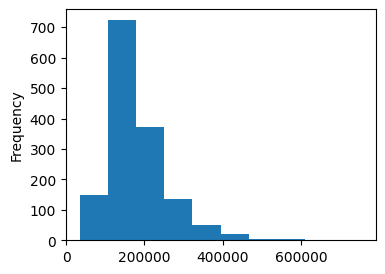

In [254]:
# Target
data.SalePrice.plot.hist(figsize = (4,3))
data.SalePrice.describe()

count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64

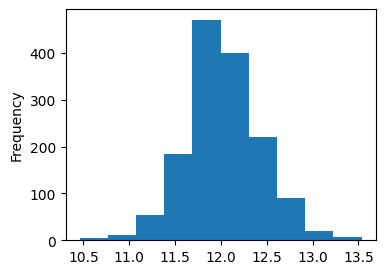

In [255]:
data.SalePrice = np.log(data.SalePrice)
data.SalePrice.plot.hist(figsize = (4,3))
data.SalePrice.describe()

Missing values

In [256]:
data.isna().sum().sort_values(ascending=False)[:13]#/data.shape[0]*100

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageType        81
GarageFinish      81
GarageCond        81
GarageYrBlt       81
BsmtExposure      38
dtype: int64

In [258]:
quality = {'Ex':5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1, 'No': 0}

# Pool1QC
data.PoolQC[~data.PoolQC.isna()] = 'Yes'
data.PoolQC.fillna('No', inplace=True)
#data.groupby('PoolQC')['SalePrice'].mean()

# MiscFeature
data.MiscFeature[~data.MiscFeature.isna()] = 'Yes'
data.MiscFeature.fillna('No', inplace=True)
#data.groupby('MiscFeature')['SalePrice'].mean()

# Alley
data.Alley[data.Alley.isna()] = 'No alley access'
#data.groupby('Alley')['SalePrice'].mean()

# Fence
data.Fence[~data.Fence.isna()] = 'Yes'
data.Fence.fillna('No', inplace=True)
#data.groupby('Fence')['SalePrice'].mean()

# MasVnrType
data.MasVnrType.fillna('Not Reported', inplace=True)
#data.groupby('MasVnrType')['SalePrice'].mean()

# FireplaceQu
#data.FireplaceQu[~data.FireplaceQu.isna()] = 'Yes'
data.FireplaceQu.fillna('No', inplace=True)
#data.FireplaceQu = data.FireplaceQu.map(quality)
#data.groupby('FireplaceQu')['SalePrice'].mean()

# LotFrontage
lotshape_medians = data.groupby("LotShape")["LotFrontage"].median()
data["LotFrontage"] = data["LotFrontage"].fillna(data["LotShape"].map(lotshape_medians))

# GarageQual
data.GarageQual.fillna('No', inplace=True)
#data.GarageQual = data.GarageQual.map(quality)
#data.groupby('GarageQual')['SalePrice'].mean()

# Garage
data.GarageFinish.fillna('No Garage', inplace=True)
data.GarageType.fillna('No Garage', inplace=True)
data.GarageCond.fillna('No', inplace=True)

# Basement
data.BsmtExposure.fillna('No Bsmnt', inplace=True)
data.BsmtFinType2.fillna('No Bsmnt', inplace=True)
data.BsmtFinType1.fillna('No Bsmnt', inplace=True)
data.BsmtCond.fillna('No', inplace=True)
data.BsmtQual.fillna('No', inplace=True)

# MasVnrArea
data.MasVnrArea.fillna(data.MasVnrArea.median(skipna=True), inplace=True)

# Electrical
data.Electrical.fillna(data.Electrical.mode().values[0], inplace = True)

New Features

In [260]:
# Building Age
data['BuildingAge'] = data.YearBuilt.max(skipna=True) - data.YearBuilt + 1
data['Remodeling'] = (data['YearBuilt'] != data['YearRemodAdd'])

# Garage Age
data['GarageYrBlt'] = data.GarageYrBlt.max(skipna=True) - data.GarageYrBlt + 1

# Drop unecessary cols
data.drop(columns=['YearBuilt','YearRemodAdd','GarageYrBlt'], inplace=True)

Engineering

In [261]:
# Binary cols
binary_cols = data.apply(lambda x: pd.Series(x).nunique() == 2, axis = 0)
print(f'Number of binary cols: {binary_cols.sum()}')
binary_cols = binary_cols[binary_cols].index.tolist()
print(binary_cols)
for col in binary_cols:
    dict_col = {data[col].unique()[0]:0, data[col].unique()[1]:1}
    data[col] = data[col].map(dict_col).astype('boolean')
    
# Specific cols
data.MSSubClass = data.MSSubClass.astype('O')
data.YrSold = data.YrSold.astype('O')
data.MoSold = data.MoSold.astype('O')

# Quality related cols
mask = data.columns.str.contains(r'Qu', regex=True)
cols_to_map = data.loc[:, mask].columns.difference(['OverallQual','LowQualFinSF'])
data[cols_to_map] = data[cols_to_map].apply(lambda x: x.map(quality), axis=1)

data.ExterCond = data.ExterCond.map(quality)
data.BsmtCond = data.BsmtCond.map(quality)
data.GarageCond = data.GarageCond.map(quality)
data.HeatingQC = data.HeatingQC.map(quality)

# Drop unecessary cols
data.drop(columns=['YrSold'], inplace=True)

Number of binary cols: 7
['Street', 'Utilities', 'CentralAir', 'PoolQC', 'Fence', 'MiscFeature', 'Remodeling']


Outliers

In [263]:
# Keep only numeric features
number_cols = data.drop(columns='SalePrice').select_dtypes(include='number')
# Give the same scale across all of them
stnd = StandardScaler()
number_cols = pd.DataFrame(stnd.fit_transform(number_cols), columns=number_cols.columns)
# Compute mean values per row
mn = number_cols.apply(lambda x: x.mean(), axis = 1)
# Remove rows extreme rows
outliers = mn.index[(mn > (mn.mean() + 4*mn.std())) | (mn < (mn.mean() - 4*mn.std()))]
# Remove outliers
data.drop(index=outliers, inplace=True)

Feature selction

In [277]:
output = {
    'Feature': []
    ,'RMSE': []
    ,'R2': []
    ,'Baseline_RMSE': []
    ,'Baseline_R2': []
    ,
    }
for col in data.drop(columns='SalePrice').columns:
    d = data[[col, 'SalePrice']].dropna()
    Xtrain, Xtest, ytrain, ytest = train_test_split(d[[col]], d.SalePrice, test_size=0.2, random_state=999)

    if not pd.api.types.is_numeric_dtype(Xtrain[col]):
        Xtrain = pd.get_dummies(Xtrain, drop_first=True)
        Xtest = pd.get_dummies(Xtest, drop_first=True)
        Xtest = Xtest.reindex(columns=Xtrain.columns, fill_value=0)

    # Model
    lr = LinearRegression()
    lr_model = lr.fit(Xtrain, ytrain)
    pred = lr_model.predict(Xtest)

    # Baseline model
    baseline_pred = np.full_like(ytest, ytrain.mean(), dtype=float)
    
    # Output
    output['Feature'].append(col)
    output['RMSE'].append(root_mean_squared_error(ytest, pred))
    output['R2'].append(r2_score(ytest, pred))
    output['Baseline_RMSE'].append(root_mean_squared_error(ytest, baseline_pred))
    output['Baseline_R2'].append(r2_score(ytest, baseline_pred))

output = pd.DataFrame(output).sort_values(by = 'RMSE', ascending=True).reset_index(drop=True)

In [288]:
# Top 5 most important features (univariate)
print(output.head(3))

# Remove noisy features
output = output[(output.R2 > output.Baseline_R2) & (output.RMSE < output.Baseline_RMSE)]

        Feature      RMSE        R2  Baseline_RMSE  Baseline_R2
0   OverallQual  0.216856  0.677485       0.382978    -0.005893
1  Neighborhood  0.257566  0.545031       0.382978    -0.005893
2   TotalBsmtSF  0.266280  0.513723       0.382978    -0.005893


<Axes: >

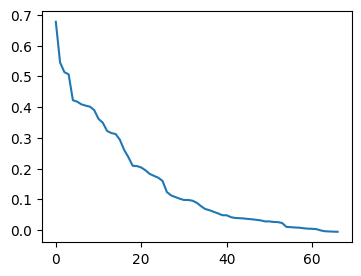

In [292]:
output.R2.plot(figsize=(4,3))

In [295]:
selected_faetures = output.Feature.tolist()
selected_faetures.append('SalePrice')

#### Visualizations

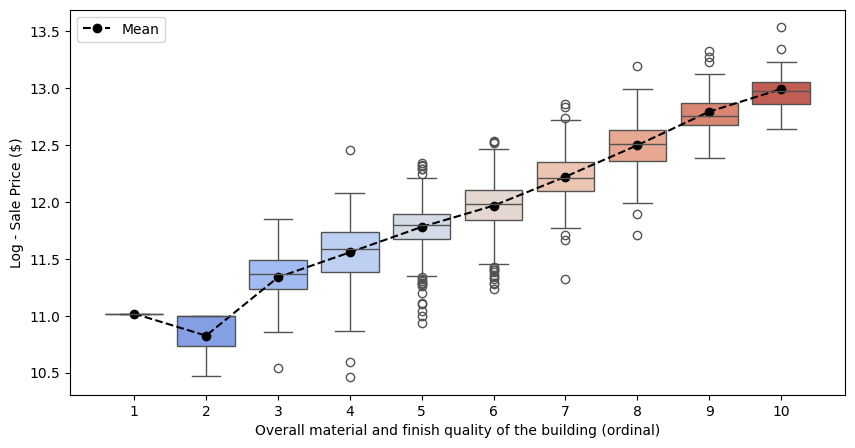

In [243]:
# Overall Quality
plt.figure(figsize=(10,5))

sns.boxplot(x='OverallQual', y='SalePrice', data=data, palette='coolwarm')
mean_prices = data.groupby('OverallQual')['SalePrice'].mean()
# Add meanline
plt.plot(np.arange(len(mean_prices)), mean_prices, color='black', marker='o', linestyle='--', label='Mean')

plt.xlabel('Overall material and finish quality of the building (ordinal)')
plt.ylabel('Log - Sale Price ($)')
plt.legend()
plt.show()

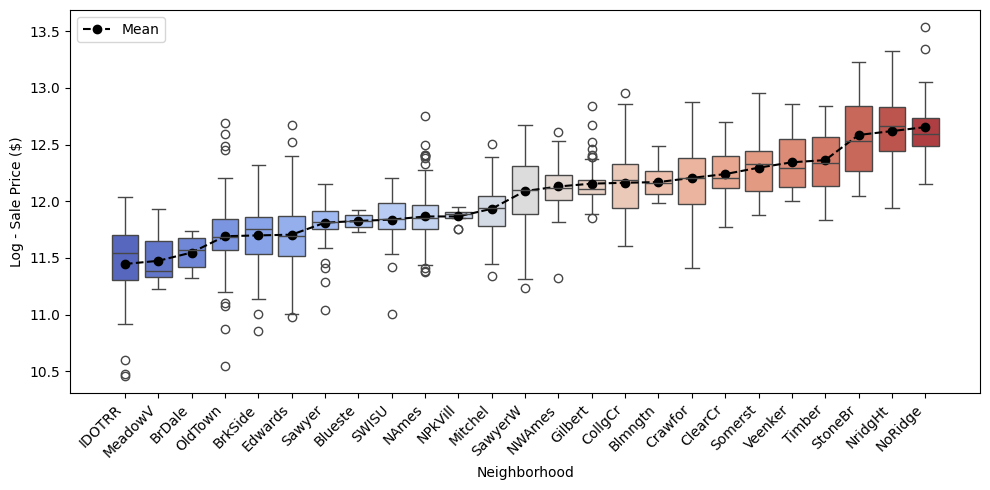

In [244]:
mean_prices = data.groupby('Neighborhood')['SalePrice'].mean().sort_values()
data['Neighborhood'] = pd.Categorical(data['Neighborhood'], categories=mean_prices.index, ordered=True)

plt.figure(figsize=(10,5))
sns.boxplot(x='Neighborhood', y='SalePrice', data=data, palette='coolwarm')
sns.stripplot(x='Neighborhood', y='SalePrice', data=data, color='None', alpha=0.3, jitter=0.2, size=3)
plt.plot(np.arange(len(mean_prices)), mean_prices.values, color='black', marker='o', linestyle='--', label='Mean')
plt.xlabel('Neighborhood')
plt.ylabel('Log - Sale Price ($)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

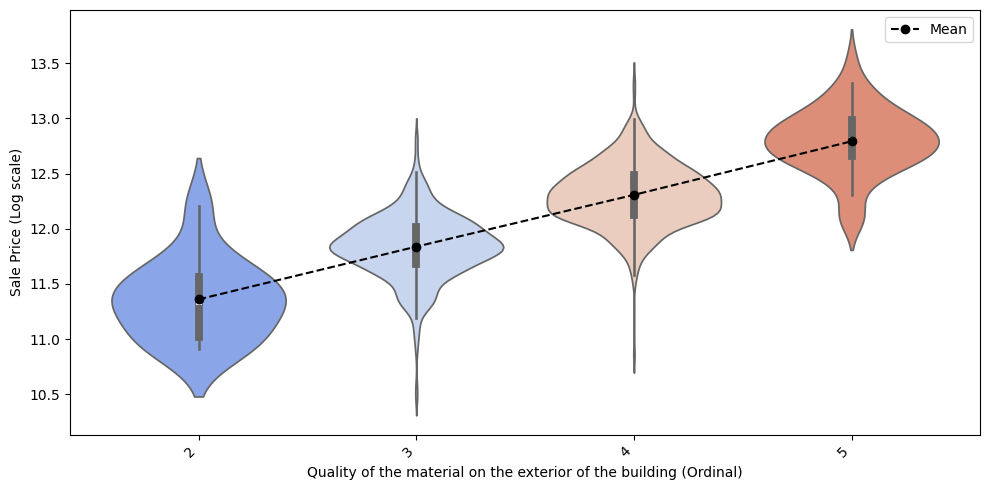

In [245]:
mean_prices = data.groupby('ExterQual')['SalePrice'].mean().sort_values()
data['ExterQual'] = pd.Categorical(data['ExterQual'], categories=mean_prices.index, ordered=True)

plt.figure(figsize=(10,5))

sns.violinplot(x='ExterQual', y='SalePrice', data=data, palette='coolwarm', scale='width')

plt.plot(np.arange(len(mean_prices)), mean_prices.values, color='black', marker='o', linestyle='--', label='Mean')
plt.xlabel('Quality of the material on the exterior of the building (Ordinal)')
plt.ylabel('Sale Price (Log scale)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


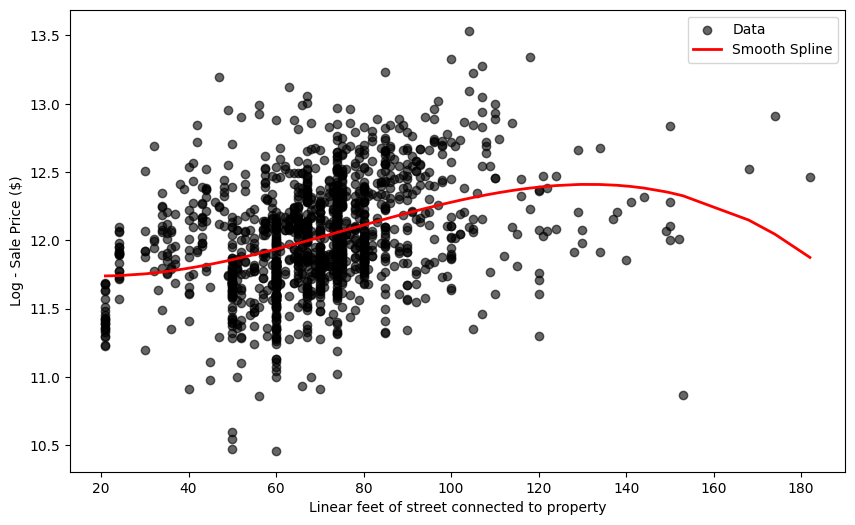

In [247]:
from scipy.interpolate import UnivariateSpline
d = data[data.LotFrontage < 300]
# Data
x = d['LotFrontage'].values
y = d['SalePrice'].values

# Sort data for spline
sorted_idx = np.argsort(x)
x_sorted = x[sorted_idx]
y_sorted = y[sorted_idx]

# Fit spline
spline = UnivariateSpline(x_sorted, y_sorted, s=1e8)  # s controls smoothness
y_smooth = spline(x_sorted)

# Plot
plt.figure(figsize=(10,6))
plt.scatter(x, y, alpha=0.6, color='black', label='Data')
plt.plot(x_sorted, y_smooth, color='red', linewidth=2, label='Smooth Spline')

plt.xlabel('Linear feet of street connected to property')
plt.ylabel('Log - Sale Price ($)')
plt.legend()
plt.show()


#### Feature Selection

In [319]:
# Keep selected features from revious selection
data = data[selected_faetures]
for col in data.select_dtypes(include='O').columns:
    data[col] = data[col].astype('category')
    
# Split data
Xtrain, Xtest, ytrain, ytest = train_test_split(data.drop(columns = 'SalePrice'), data.SalePrice, test_size=0.2, random_state=999)
Xtr, Xval, ytr, yval = train_test_split(Xtrain, ytrain, test_size=0.2, random_state=999)

In [333]:
metrics = {
    'data': ['Train', 'Test'],
    'RMSE': [],
    'R2': [],
}
xgb = XGBRegressor(
    # Base
    objective='reg:squarederror',
    booster='gbtree',
    early_stopping_rounds=1000,
    eval_metric='rmse',

    # Tree-related
    n_estimators=10**4,
    colsample_bytree=0.1,
    subsample=0.8,
    learning_rate=0.033,
    max_leaves = 12, 
    max_depth=5,
    min_child_weight = 5,
    
    # Regularization
    gamma = 1.5,
    reg_lambda = 1.5,
    alpha = 0.1,
    enable_categorical = True,
    
    random_state=42
).fit(
    Xtr, ytr,
    eval_set=[(Xval, yval)],
    verbose=0
)

metrics['RMSE'].append(root_mean_squared_error(ytr, xgb.predict(Xtr)))
metrics['RMSE'].append(root_mean_squared_error(ytest, xgb.predict(Xtest)))
metrics['R2'].append(r2_score(ytr, xgb.predict(Xtr)))
metrics['R2'].append(r2_score(ytest, xgb.predict(Xtest)))
metrics = pd.DataFrame(metrics)
metrics

,data,RMSE,R2
0,Train,0.141650,0.878790
1,Test,0.146577,0.852655


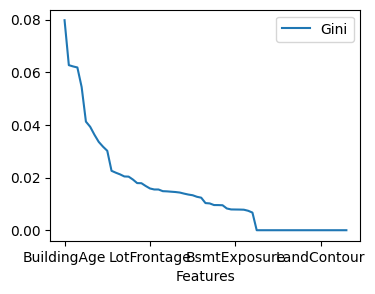

In [337]:
importance = pd.DataFrame({'Features': xgb.get_booster().feature_names, 'Gini':xgb.feature_importances_}).sort_values(by = 'Gini', ascending=False)
importance.plot(x = 'Features', y = 'Gini', figsize=(4, 3))
importance = importance[importance.Gini > 0]

Final model

In [ ]:
metrics_xgb = {
    'data': ['Train', 'Test'],
    'RMSE': [],
    'R2': [],
}
xgb = XGBRegressor(
    # Base
    objective='reg:squarederror',
    booster='gbtree',
    early_stopping_rounds=1000,
    eval_metric='rmse',

    # Tree-related
    n_estimators=10**4,
    colsample_bytree=0.1,
    subsample=0.8,
    learning_rate=0.033,
    max_leaves = 12, 
    max_depth=5,
    min_child_weight = 5,
    
    # Regularization
    gamma = 1.5,
    reg_lambda = 1.5,
    alpha = 0.1,
    enable_categorical = True,
    
    random_state=42
).fit(
    Xtr, ytr,
    eval_set=[(Xval, yval)],
    verbose=0
)

metrics_xgb['RMSE'].append(root_mean_squared_error(ytr, xgb.predict(Xtr)))
metrics_xgb['RMSE'].append(root_mean_squared_error(ytest, xgb.predict(Xtest)))
metrics_xgb['R2'].append(r2_score(ytr, xgb.predict(Xtr)))
metrics_xgb['R2'].append(r2_score(ytest, xgb.predict(Xtest)))
metrics_xgb = pd.DataFrame(metrics_xgb)
metrics_xgb

In [352]:
metrics_lgb = {
    'data': ['Train', 'Test'],
    'RMSE': [],
    'R2': [],
}
lgb = lightgbm.LGBMRegressor(
    objective='regression_l2',
    boosting_type='gbdt',
    
    n_estimators=10**4,
    learning_rate=0.033,
    metric='rmse',
    colsample_bytree=0.05,
    early_stopping_rounds = 200,
    
    min_child_samples = 5,
    max_depth=4,
    subsample=0.8,
    num_leaves= 7,
    
    random_state=42,
    verbose = 1000,
    force_row_wise=True
).fit(
    Xtr, ytr,
    eval_set=[(Xval, yval)],
    eval_metric='rmse'
)

metrics_lgb['RMSE'].append(root_mean_squared_error(ytr, lgb.predict(Xtr)))
metrics_lgb['RMSE'].append(root_mean_squared_error(ytest, lgb.predict(Xtest)))
metrics_lgb['R2'].append(r2_score(ytr, lgb.predict(Xtr)))
metrics_lgb['R2'].append(r2_score(ytest, lgb.predict(Xtest)))
metrics_lgb = pd.DataFrame(metrics_lgb)
metrics_lgb

[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.477667
[LightGBM] [Info] Total Bins 2729
[LightGBM] [Info] Number of data points in the train set: 930, number of used features: 66
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Info] Start training from score 12.022996
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 4
Training until validation scores don't improve for 200 rounds
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 4
[LightGBM] [Debug] Train

,data,RMSE,R2
0,Train,0.075113,0.965917
1,Test,0.122915,0.896387
